In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)

Multicore TSNE not installed, tsne maps will not be able to be calculated
Gensim not installed, you will need this for running Doc2Vec models


# Get the labelled documents in the right order, and check if we are ready to stop screening

In [2]:
# Here are the labels in the order they were created
dos = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query__project=338, relevant__gt=0).order_by('id').values('id','doc_id'))
       .groupby('doc_id')
       .first()
       .sort_values('id')
       .reset_index()
       .reset_index()
       .drop(columns="id")
       .rename(columns={"doc_id":"id","index":"order"})
      )
dos.head()

,order,id
0,0,268305
1,1,778080
2,2,1022233
3,3,1049060
4,4,1051383


In [3]:
# Here are the unlabelled documents 
unlabelled_docs = pd.read_csv('data/0_unlabelled_documents.csv')

# And the labelled ones, in the order they were seen
df = pd.read_csv("data/0_labelled_documents.csv").merge(dos,how="left")
df.loc[~df['id'].isin(dos.id),'order'] = -1
df = df.sort_values('order').reset_index(drop=True)
df = df[pd.notna(df['relevant'])].reset_index(drop=True)
print(df.shape)

n_docs = df.shape[0] + unlabelled_docs.shape[0]

df.tail()

(3083, 9)


,id,content,title,tslug,wosarticle__de,wosarticle__wc,relevant,seen,order
3078,5379636,Prior research among adolescents and emerging ...,The impact of feedback valence and communicati...,theimpactoffeedbackvalenceandcommunicationstyl...,NaN,NaN,0,1.0,3079
3079,5365334,BACKGROUND: Many adolescent girls had a lack o...,The effect of anemia free club interventions t...,theeffectofanemiafreeclubinterventionstoimprov...,NaN,NaN,0,1.0,3080
3080,5365627,… participants reported higher intake of fruit...,Prebiotic effects of partially hydrolyzed guar...,prebioticeffectsofpartiallyhydrolyzedguargumon...,NaN,NaN,0,1.0,3081
3081,4132133,This paper builds a Food Delivery Network (Foo...,FooDNet: Toward an Optimized Food Delivery Net...,foodnettowardanoptimizedfooddeliverynetworkbas...,Spatial Crowdsouring; online takeout ordering ...,"['Computer Science, Information Systems; Telec...",0,1.0,3082
3082,4851494,The aim of this study was to analyze the effec...,The effect of shearing in a hot environment on...,theeffectofshearinginahotenvironmentonsomewelf...,Heat stress; Individual behavior; Rectal tempe...,"['Agriculture, Dairy & Animal Science; Veterin...",0,1.0,3083


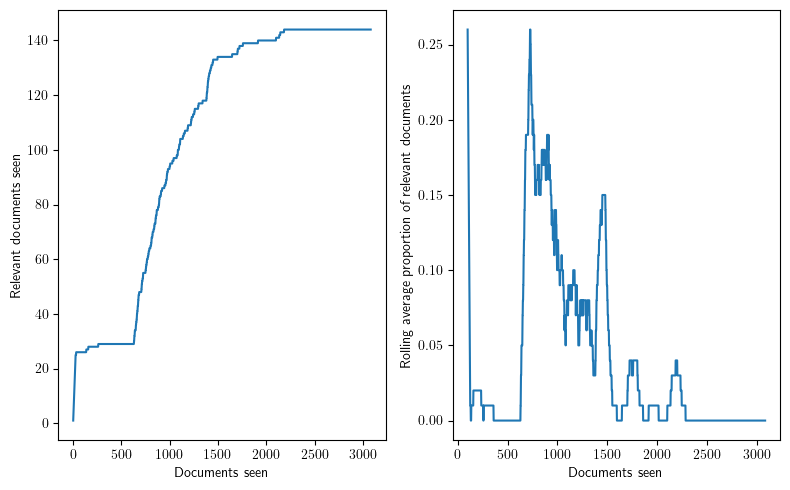

In [4]:
# Here's the progress we are making so far
fig, axs = plt.subplots(1,2,figsize=(8,5))
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")

df.relevant.rolling(window=100).mean().plot(ax=axs[1])
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("Rolling average proportion of relevant documents")

fig.tight_layout()

plt.savefig("figures/progress.pdf",bbox_inches="tight")
plt.savefig("figures/progress.png",bbox_inches="tight", dpi=200)

In [5]:
# Here's how we calculate the minimum number of relevant documents in our sample consistent with the null hypothesis
import math
def get_K_hat(r_seen,tau_target,r_ML):
    return(math.floor(r_seen/tau_target - r_ML+1))

vec_get_K_hat = np.vectorize(get_K_hat)

In [6]:
# These are the recall targets we want to assess
tau_targets = [
    #{"tau_target": 0.5},
    #{"tau_target": 0.66},
    {"tau_target": 0.75},
    {"tau_target": 0.9},
    {"tau_target": 0.95}
]

In [7]:
from scipy.stats import hypergeom

for t in tau_targets:
    t['ps'] = np.zeros(df.shape[0])
    # Go through the index in steps of 50
    for i in df.index[::50]:
        docs = df.relevant.values[:i+1] # These are all the documents we consider in this step
        sample = docs[::-1] # This will be considered a random sample, that is we treat the last 1, last 2... documents as a random sample
        r_seen = docs.sum() # This is the total number of relevant docs seen at this point
        K_hat = vec_get_K_hat(
            r_seen, # The total number of relevant documents seen
            t['tau_target'], # The recall target
            r_seen-sample.cumsum() # The number of relevant documents seen before the sample began
        )
        n_sample = np.arange(1,sample.shape[0]+1) # the number of documents in the sample (an array from 1 to maximum sample length)
        p = hypergeom.cdf( # the probability of observing
            sample.cumsum(), # the number of relevant documents in the sample
            n_docs - i + n_sample, # In a population made up out of the sample and all remaining docs 
            K_hat, # Where K_hat docs in the population are actually relevant
            n_sample # After observing this many documents
        )
        t['ps'][i] = min(p)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

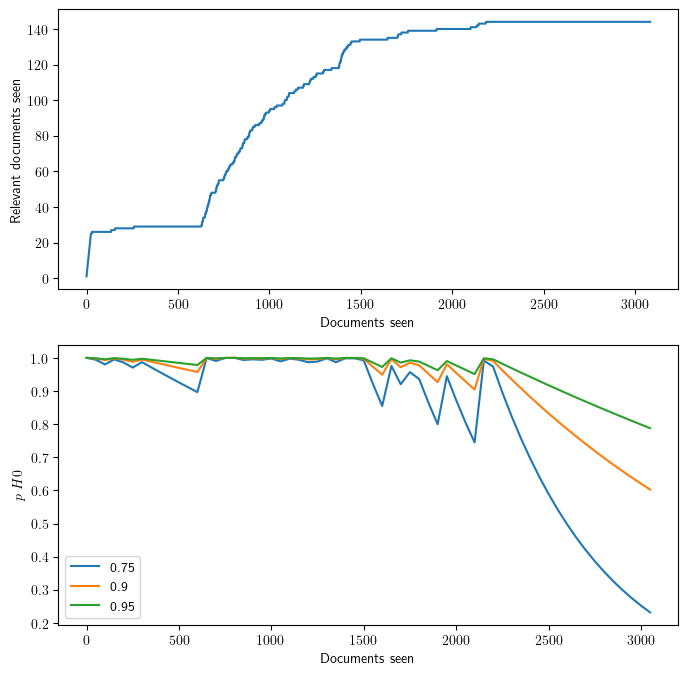

In [8]:
from IPython.display import display, Latex

# Here's the progress we are making so far
fig, axs = plt.subplots(2,1,figsize=(8,8))
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")

for t in tau_targets:
    t['ps'][t['ps']==0] = np.NaN
    y = t['ps'][~np.isnan(t['ps'])]
    x = np.argwhere(~np.isnan(t['ps']))
    axs[1].plot(x,y,label=t['tau_target'])
    display(Latex(f"$p={min(y):.2}$ for $H_0$ that recall of {t['tau_target']} has not been achieved"))
    
axs[1].legend()
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("$p$ $H0$")

plt.savefig("figures/progress_unbiased.pdf",bbox_inches="tight")
plt.savefig("figures/progress_unbiased.png",bbox_inches="tight", dpi=200)


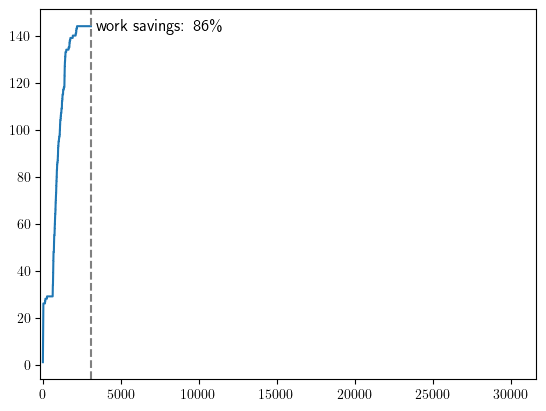

In [9]:
fig, ax = plt.subplots()
df.relevant.cumsum().plot(ax=ax)
#ax.plot([0,n_docs],[0,df.relevant.sum()/0.95],c="grey", ls="--")
ax.set_xlim(xmax=n_docs)

ws = (n_docs - df.shape[0]) / n_docs*0.95

ax.axvline(df.shape[0], ls="--", color="grey")

ax.text(
    df.shape[0]+n_docs*0.01, 
    df.relevant.sum(), 
    fr" work savings: {ws:.0%}".replace("%","\%"),
    va="center",
    fontsize=12
)
plt.savefig("figures/work_savings.pdf",bbox_inches="tight")
plt.savefig("figures/work_savings.png",bbox_inches="tight", dpi=200)

In [10]:
df.relevant.sum()/0.95-df.relevant.sum()

7.578947368421069

In [11]:
# These are the recall targets we want to assess
biased_tau_targets = [
    #{"tau_target": 0.5},
    #{"tau_target": 0.66},
    {"tau_target": 0.75},
    {"tau_target": 0.9},
    {"tau_target": 0.95}
]

from scipy.stats import nchypergeom_fisher

urn_bias = 10

for t in biased_tau_targets:
    t['ps'] = np.zeros(df.shape[0])
    # Go through the index in steps of 50
    for i in df.index[::50]:
        docs = df.relevant.values[:i+1] # These are all the documents we consider in this step
        sample = docs[::-1] # This will be considered a random sample, that is we treat the last 1, last 2... documents as a random sample
        r_seen = docs.sum() # This is the total number of relevant docs seen at this point
        K_hat = vec_get_K_hat(
            r_seen, # The total number of relevant documents seen
            t['tau_target'], # The recall target
            r_seen-sample.cumsum() # The number of relevant documents seen before the sample began
        )
        n_sample = np.arange(1,sample.shape[0]+1) # the number of documents in the sample (an array from 1 to maximum sample length)
        p = nchypergeom_fisher.cdf( # the probability of observing
            sample.cumsum(), # the number of relevant documents in the sample
            n_docs - i + n_sample, # In a population made up out of the sample and all remaining docs 
            K_hat, # Where K_hat docs in the population are actually relevant
            n_sample, # After observing this many documents
            urn_bias
        )
        t['ps'][i] = min(p)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

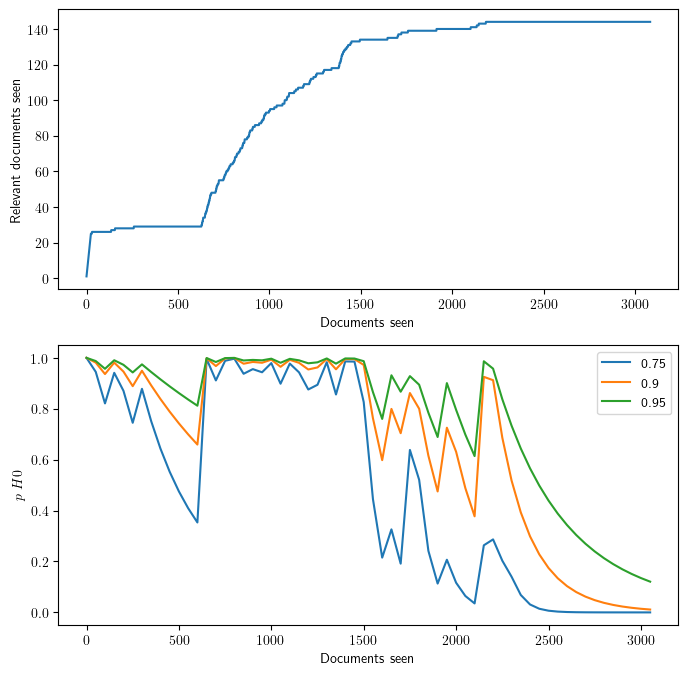

In [12]:
from IPython.display import display, Latex

# Here's the progress we are making so far
fig, axs = plt.subplots(2,1,figsize=(8,8))
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")

for t in biased_tau_targets:
    t['ps'][t['ps']==0] = np.NaN
    y = t['ps'][~np.isnan(t['ps'])]
    x = np.argwhere(~np.isnan(t['ps']))
    axs[1].plot(x,y,label=t['tau_target'])
    display(Latex(f"$p={min(y):.2}$ for $H_0$ that recall of {t['tau_target']} has not been achieved"))
    
axs[1].legend()
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("$p$ $H0$")

plt.savefig("figures/progress_biased_10.pdf",bbox_inches="tight")
plt.savefig("figures/progress_biased_10.png",bbox_inches="tight", dpi=200)

In [13]:
# These are the recall targets we want to assess
biased_tau_targets = [
    #{"tau_target": 0.5},
    #{"tau_target": 0.66},
    {"tau_target": 0.75},
    {"tau_target": 0.9},
    {"tau_target": 0.95}
]

from scipy.stats import nchypergeom_fisher

urn_bias = 5

for t in biased_tau_targets:
    t['ps'] = np.zeros(df.shape[0])
    # Go through the index in steps of 50
    for i in df.index[::50]:
        docs = df.relevant.values[:i+1] # These are all the documents we consider in this step
        sample = docs[::-1] # This will be considered a random sample, that is we treat the last 1, last 2... documents as a random sample
        r_seen = docs.sum() # This is the total number of relevant docs seen at this point
        K_hat = vec_get_K_hat(
            r_seen, # The total number of relevant documents seen
            t['tau_target'], # The recall target
            r_seen-sample.cumsum() # The number of relevant documents seen before the sample began
        )
        n_sample = np.arange(1,sample.shape[0]+1) # the number of documents in the sample (an array from 1 to maximum sample length)
        p = nchypergeom_fisher.cdf( # the probability of observing
            sample.cumsum(), # the number of relevant documents in the sample
            n_docs - i + n_sample, # In a population made up out of the sample and all remaining docs 
            K_hat, # Where K_hat docs in the population are actually relevant
            n_sample, # After observing this many documents
            urn_bias
        )
        t['ps'][i] = min(p)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

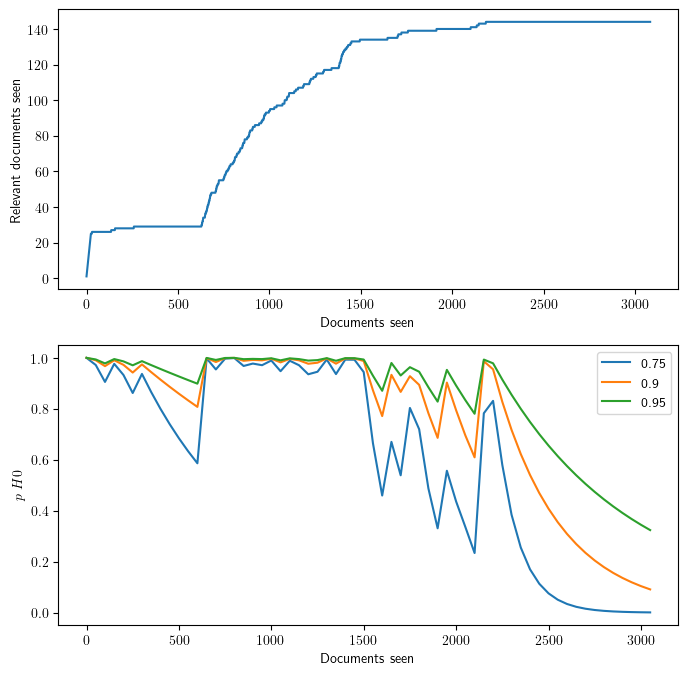

In [14]:
from IPython.display import display, Latex

# Here's the progress we are making so far
fig, axs = plt.subplots(2,1,figsize=(8,8))
df.relevant.cumsum().plot(ax=axs[0])
axs[0].set_xlabel("Documents seen")
axs[0].set_ylabel("Relevant documents seen")

for t in biased_tau_targets:
    t['ps'][t['ps']==0] = np.NaN
    y = t['ps'][~np.isnan(t['ps'])]
    x = np.argwhere(~np.isnan(t['ps']))
    axs[1].plot(x,y,label=t['tau_target'])
    display(Latex(f"$p={min(y):.2}$ for $H_0$ that recall of {t['tau_target']} has not been achieved"))
    
axs[1].legend()
axs[1].set_xlabel("Documents seen")
axs[1].set_ylabel("$p$ $H0$")

plt.savefig("figures/progress_biased_5.pdf",bbox_inches="tight")
plt.savefig("figures/progress_biased_5.png",bbox_inches="tight", dpi=200)

# Now predict the most relevant of the remaining results and assign them to screeners

In [13]:
# Now load and merge the seen and unseen documents
seen_df = pd.read_csv('data/0_labelled_documents.csv')
unseen_df = pd.read_csv('data/0_unlabelled_documents.csv')
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head()

(31462, 9)


,id,content,title,tslug,wosarticle__de,wosarticle__wc,relevant,seen,random_sample
0,5358967,Background: Studies of genes that play an impo...,Effect of a diet containing folate and hazelnu...,effectofadietcontainingfolateandhazelnutoilcap...,ADRB3; Obesity; DNA methylation; Biochemical a...,['Oncology; Genetics & Heredity'],0,0.0,0.0
1,5378052,Positive health behaviour by eating nutritious...,Online social networks for health behaviour ch...,onlinesocialnetworksforhealthbehaviourchangede...,Online social networks; Health behaviour; User...,"['Psychology, Multidisciplinary; Psychology, E...",0,0.0,0.0
2,5352308,IgE-mediated immediate type reactions are the ...,Food allergy in childhood,foodallergyinchildhood,Food hypersensitivity; Anaphylaxis; Diagnostic...,"['Public, Environmental & Occupational Health']",0,0.0,0.0
3,5376018,The aim of the present study was to examine pe...,Imagined salad and steak restaurants: Consumer...,imaginedsaladandsteakrestaurantsconsumerscolou...,NaN,NaN,0,0.0,0.0
4,5386388,Choice experiments (CE) are one of the most po...,Testing commitment cost in food choices: a non...,testingcommitmentcostinfoodchoicesanonhypothet...,Business And Economics; ideas.repec.org/p/ags/...,NaN,0,1.0,NaN


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Here we define the whole ML pipeline starting from creating features to training a classifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(probability=True,  class_weight="balanced")),
])

# Now we define the parameter space we want to search. This gets computationally expensive the 
# more parameters we search, as we fit a model for every unique combination of parameters (there are fancier and smarter ways to do this)

parameters = [
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['rbf'], 
        'clf__gamma': [1e-3, 1e-4], # Because only the rbf kernel has the gamma parameters, we do this separately
        'clf__C': [1, 1e1, 1e2]
    },
    {
        'vect__max_df': (0.5,),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['linear'], 
        'clf__C': [1e2, 1e3]
    }
]

clf = GridSearchCV(pipeline, parameters, scoring="f1", n_jobs=4, verbose=1)

In [15]:
# We can either retrain this each time, or load it with the best performing model from last time
retrain = False
if retrain:
    # Now we fit them, by default we try a model for each set of parameters for 5 folds of train/test data
    # Even with this running in parallel (n_jobs=8) this might be time to get a coffee
    clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'relevant'])
    # The best model is the combination of parameters with the highest mean score across 5 folds
    clf.best_estimator_
    results = pd.DataFrame(clf.cv_results_)
    results.head()
    f1_scores = [results[f"split{x}_test_score"].values[0] for x in range(5)]
    print(np.mean(f1_scores))

    fig, ax = plt.subplots()

    ax.boxplot(f1_scores)
    ax.set_ylim([0,1])
    ax.grid(axis="y")
    ax.set_xticklabels(["Best performing model"])
    ax.set_ylabel('F1 score')
else:
    # No time to retrain, we'll just take the pipeline with the best performance from last time
    clf = Pipeline(steps=[
        ('vect', TfidfVectorizer(max_df=0.5, min_df=5, ngram_range=(1,2))),
        ('clf', SVC(C=100.0, class_weight='balanced', probability=True))
    ])
    clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'relevant'])

144


/tmp/ipykernel_1375254/2877162169.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prediction'][unseen_index] = y_pred[:,1]


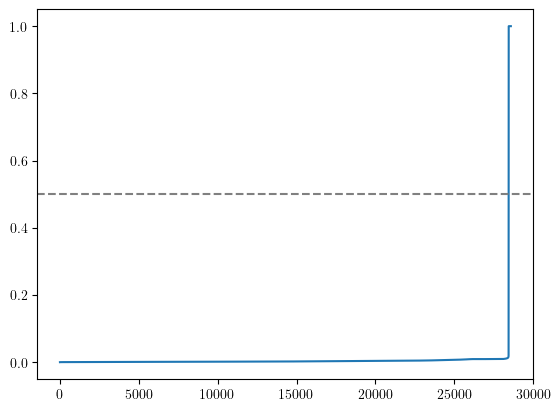

In [16]:
# Use the trained best performing model to predict the relevance of the unseen documents
y_pred = clf.predict_proba(df.loc[unseen_index,'content'])

# Put these predictions in the "prediction" column of the dataframe
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]

# plot the predictions in order
fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

# How many documents have a predicted value greater than 0.5?
print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [17]:
django.db.connection.close()

q = Query.objects.get(pk=10997)
doids = set(DocOwnership.objects.filter(tag__query__project=q.project).values_list('doc__id',flat=True))
len(doids)

2880

1168

In [21]:
django.db.connection.close()


q = Query.objects.get(pk=10997)
# Make a new tag
tag, created = Tag.objects.get_or_create(
    query=q,
    title="ML Prioritised 1_5"
)

pairs = [

    [['api.msc@cbs.dk', 'pml44@cam.ac.uk'], 750],

]


doids = set(DocOwnership.objects.filter(tag__query__project=q.project).values_list('doc__id',flat=True))


assign_docs = (df[~df['id'].isin(doids)]
            .sort_values('prediction',ascending=False)
            .reset_index(drop=True)
           )


for i, row in assign_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    
    pairs = [p for p in pairs if p[1] > 0]
    if len(pairs)==0:
        print("Run out of pairs")
        break
    d.tag.add(tag)
    p = pairs[i % len(pairs)]
    users = User.objects.filter(username__in=p[0])
    for user in users:
        do, created = DocOwnership.objects.get_or_create(
            query=q,
            tag=tag,
            doc=d,
            user=user
        )
    p[1] = p[1] - 1
    

        
tag.update_tag()

Run out of pairs


In [ ]:

djangodbb.connection.close()

q = Query.objects.get(pk=10997)
# Make a new tag
tag, created = Tag.objects.get_or_create(
    query=q,
    title="ML Prioritised 1_4"
)

pairs = [

    [['api.msc@cbs.dk', 'pml44@cam.ac.uk'], 150],

    [['pml44@cam.ac.uk','bca.msc@cbs.dk'], 175],

    [['pml44@cam.ac.uk','jmb.msc@cbs.dk'], 75],

    [['api.msc@cbs.dk','jmb.msc@cbs.dk'], 125],

    [['ctm41@cam.ac.uk','ljg61@cam.ac.uk'], 75],

    [['api.msc@cbs.dk','ctm41@cam.ac.uk'], 150],

]


doids = set(DocOwnership.objects.filter(tag__query__project=q.project).values_list('doc__id',flat=True))


assign_docs = (df[~df['id'].isin(doids)]
            .sort_values('prediction',ascending=False)
            .reset_index(drop=True)
           )


for i, row in assign_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    
    pairs = [p for p in pairs if p[1] > 0]
    if len(pairs)==0:
        print("Run out of pairs")
        break
    d.tag.add(tag)
    p = pairs[i % len(pairs)]
    users = User.objects.filter(username__in=p[0])
    for user in users:
        do, created = DocOwnership.objects.get_or_create(
            query=q,
            tag=tag,
            doc=d,
            user=user
        )
    p[1] = p[1] - 1
    

        
tag.update_tag()

In [ ]:

django.db.connection.close()

q = Query.objects.get(pk=10997)
# Make a new tag
tag, created = Tag.objects.get_or_create(
    query=q,
    title="ML Prioritised 1_2"
)



pairs = [

    [['pml44@cam.ac.uk','bca.msc@cbs.dk'], 150],

    [['api.msc@cbs.dk','ljg61@cam.ac.uk'], 75],

    [['pml44@cam.ac.uk','ctm41@cam.ac.uk'], 225],

    [['api.msc@cbs.dk','jmb.msc@cbs.dk'], 150],

    [['api.msc@cbs.dk', 'pml44@cam.ac.uk'], 150],

]

doids = set(DocOwnership.objects.filter(tag__query__project=q.project).values_list('doc__id',flat=True))


assign_docs = (df[~df['id'].isin(doids)]
            .sort_values('prediction',ascending=False)
            .reset_index(drop=True)
           )


for i, row in assign_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    
    pairs = [p for p in pairs if p[1] > 0]
    if len(pairs)==0:
        print("Run out of pairs")
        break
    d.tag.add(tag)
    p = pairs[i % len(pairs)]
    users = User.objects.filter(username__in=p[0])
    for user in users:
        do, created = DocOwnership.objects.get_or_create(
            query=q,
            tag=tag,
            doc=d,
            user=user
        )
    p[1] = p[1] - 1
    

        
tag.update_tag()

In [ ]:
import datetime

django.db.connection.close()
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=9559)

tag, created = Tag.objects.get_or_create(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()


users = q.users.all()
uc = len(users)

doids = set(DocOwnership.objects.filter(query__project=q.project).values_list('doc__id',flat=True))

new_docs = (df[~df['id'].isin(doids)]
            .sort_values('prediction',ascending=False)
            .head(370)
            .reset_index(drop=True)
           )

pairs = [
    ["srivastavap@iiasa.ac.at","james.milner@lshtm.ac.uk"],
    ["emma.hutchinson@lshtm.ac.uk", "catalina.turcu@ucl.ac.uk"],
]



for i, row in new_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    pair = pairs[i % len(pairs)]
    users = User.objects.filter(username__in=pair)
    for u in users:
        do, created = DocOwnership.objects.get_or_create(
            doc=d,
            user=u,
            query=q,
            tag=tag
        )
        do.save()
    
tag.update_tag()
tag.title